# Environment Setup
Datasetthese commands TODO: org

Push a Nvidia repo to your artifact repository - (create a new repo if not available)

The "new repo" would be us-central1-docker.pkg.dev/hybrid-vertex/merlin/ below

```
sudo docker pull nvcr.io/nvidia/merlin/merlin-hugectr:22.06
sudo docker tag nvcr.io/nvidia/merlin/merlin-hugectr:22.06 us-central1-docker.pkg.dev/hybrid-vertex/merlin/merlin-hugectr:22.06
sudo docker push us-central1-docker.pkg.dev/hybrid-vertex/merlin/merlin-hugectr:22.06
docker run  -d --gpus all --rm -it -p 8888:8888 -p 8797:8787 -p 8796:8786 --ipc=host --cap-add SYS_NICE us-central1-docker.pkg.dev/hybrid-vertex/merlin/merlin-hugectr:22.06 
jupyter-lab --allow-root --ip='0.0.0.0' --NotebookApp.token=''
git clone https://github.com/NVIDIA-Merlin/Merlin.git


docker run  -d --gpus all --rm -it -p 8888:8888 -p 8797:8787 -p 8796:8786 --ipc=host --cap-add SYS_NICE nvcr.io/nvidia/merlin/merlin-hugectr:22.06 
```


# Training with Merlin

Spotify example

The goal of this notebook is todo

based heavily on [this](https://github.com/NVIDIA-Merlin/models/blob/main/examples/05-Retrieval-Model.ipynb) NVIDIA resource


Data is loaded from BQ - to parquet using the job configuration below

```
BUCKET = 'gs://spotify-builtin-2t'
PROJECT = 'hybrid-vertex'
DATASET_ID = 'spotify_train_3'
TABLE = 'train_flatten'
TABLE_SMALL = 'train_json_export_table_small'
LOCATION = 'us-central1'

from google.cloud import bigquery
client = bigquery.Client()

destination_uri = f"{BUCKET}/train_data_parquet/*.snappy.parquet"
dataset_ref = bigquery.DatasetReference(PROJECT, DATASET_ID)
table_ref = dataset_ref.table(TABLE)
job_config = bigquery.job.ExtractJobConfig()
job_config.destination_format = bigquery.DestinationFormat.PARQUET
extract_job = client.extract_table(
    table_ref,
    destination_uri,
    job_config=job_config,
    # Location must match that of the source table.
    location=LOCATION,
)  # API request
extract_job.result()  # Waits for job to complete.
```


Info on the data

* track_uri_seed counts: 2249561
* artist_uri_seed counts: 294110
* album_uri_seed counts: 730377

In [5]:
# !pip upgrade pip
# !pip install gcsfs gsutil tensorflow google-auth<2
!pip install gcsfs

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.2/141.2 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.7/158.7 KB 235.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 KB 246.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2021.7.0
    Uninstalling fsspec-2021.7.0:
      Successfully uninstalled fsspec-2021.7.0
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [1]:
import os
import nvtabular as nvt
from time import time

# disable INFO and DEBUG logging everywhere
import logging

logging.disable(logging.WARNING)

from nvtabular.ops import (
    Categorify,
    TagAsUserID,
    TagAsItemID,
    TagAsItemFeatures,
    TagAsUserFeatures,
    AddMetadata,
    ListSlice
)
import nvtabular.ops as ops

from merlin.schema.tags import Tags

import merlin.models.tf as mm
from merlin.io.dataset import Dataset
import tensorflow as tf

# for running this example on CPU, comment out the line below
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

2022-07-29 21:08:42.003918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 21:08:42.004567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 21:08:42.004813: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 21:08:42.054778: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate 

### Install package to access gcs data

In [2]:
BUCKET = 'gs://spotify-builtin-2t'
PROJECT = 'hybrid-vertex'

LOCATION = 'us-central1'
# 000000000000.snappy.parquet - example record output
train = nvt.Dataset(f"{BUCKET}/train_data_parquet/0000000000**.snappy.parquet")
valid = nvt.Dataset(f"{BUCKET}/validation_data_parquet/00000000000*.snappy.parquet")
MAX_PADDING = 375
# train = nvt.Dataset(f"{BUCKET}/train_data_parquet/*.snappy.parquet")
# valid = nvt.Dataset(f"{BUCKET}/validation_data_parquet/*.snappy.parquet")

/usr/local/lib/python3.8/dist-packages/cudf/core/dataframe.py:1292: UserWarning: The deep parameter is ignored and is only included for pandas compatibility.
  warnings.warn(


#### Use `cardinality_memory_limit` or `max_size` to ensure lookups fit in memory 

```
cardinality_memory_limit: int or str, default None
    Upper limit on the "allowed" memory usage of the internal DataFrame and Table objects
    used to store unique categories. By default, this limit is 12.5% of the total memory.
    Note that this argument is meant as a guide for internal optimizations and UserWarnings
    within NVTabular, and does not guarantee that the memory limit will be satisfied.
```

In [3]:
# ?Categorify

In [4]:
item_id = ["track_uri_can"] >> Categorify(dtype="int32") >> ops.TagAsItemID() >> ops.AddMetadata(tags=["user_item"])
playlist_id = ["pid_pos_id"] >> Categorify(dtype="int32") >> TagAsUserID() 


item_features_cat = ['artist_name_can',
        'track_name_can',
        'artist_genres_can',
    ]

item_features_cont = [
        'duration_ms_can',
        'track_pop_can',
        'artist_pop_can',
        'artist_followers_can',
    ]

playlist_features_cat = [
        'artist_name_seed_track',
        'artist_uri_seed_track',
        'track_name_seed_track',
        'track_uri_seed_track',
        'album_name_seed_track',
        'album_uri_seed_track',
        'artist_genres_seed_track',
        'description_pl',
        'name',
        'collaborative',
    ]

playlist_features_cont = [
        'duration_seed_track',
        'track_pop_seed_track',
        'artist_pop_seed_track',
        'artist_followers_seed_track',
        'duration_ms_seed_pl',
        'n_songs_pl',
        'num_artists_pl',
        'num_albums_pl',
    ]

#subset of features to be tagged
seq_feats_cont = [
        'duration_ms_songs_pl',
        'artist_pop_pl',
        'artists_followers_pl',
        'track_pop_pl',
    ]

seq_feats_cat = [
        'artist_name_pl',
        # 'track_uri_pl',
        'track_name_pl',
        'album_name_pl',
        'artist_genres_pl',
        # 'pid_pos_id', 
        # 'pos_pl'
    ]

CAT = playlist_features_cat + item_features_cat
CONT = item_features_cont + playlist_features_cont

item_feature_cat_node = item_features_cat >> nvt.ops.FillMissing()>> Categorify(dtype="int32") >> TagAsItemFeatures()

item_feature_cont_node =  item_features_cont >> nvt.ops.FillMissing() >>  nvt.ops.Normalize() >> TagAsItemFeatures()

playlist_feature_cat_node = playlist_features_cat >> nvt.ops.FillMissing() >> Categorify(dtype="int32") >> TagAsUserFeatures() >> AddMetadata(Tags.CONTEXT)

playlist_feature_cont_node = playlist_features_cont >> nvt.ops.FillMissing() >>  nvt.ops.Normalize() >> TagAsUserFeatures() >> AddMetadata(Tags.CONTEXT)

playlist_feature_cat_seq_node = seq_feats_cat >> nvt.ops.FillMissing() >> Categorify(dtype="int32") >> ListSlice(MAX_PADDING, pad=True, pad_value=0) >> TagAsUserFeatures() >> nvt.ops.AddTags(Tags.SEQUENCE) 

playlist_feature_cont_seq_node = seq_feats_cont >> nvt.ops.FillMissing() >>  nvt.ops.Normalize() >> ListSlice(MAX_PADDING, pad=True, pad_value=0) >> TagAsUserFeatures() >> nvt.ops.AddTags(Tags.SEQUENCE)

In [5]:
# define a workflow
output = item_id \
+ item_feature_cat_node \
+ item_feature_cont_node \
+ playlist_feature_cat_node \
+ playlist_feature_cont_node \
+ playlist_feature_cont_seq_node \
+ playlist_feature_cat_seq_node 
# + playlist_id 


workflow = nvt.Workflow(output)

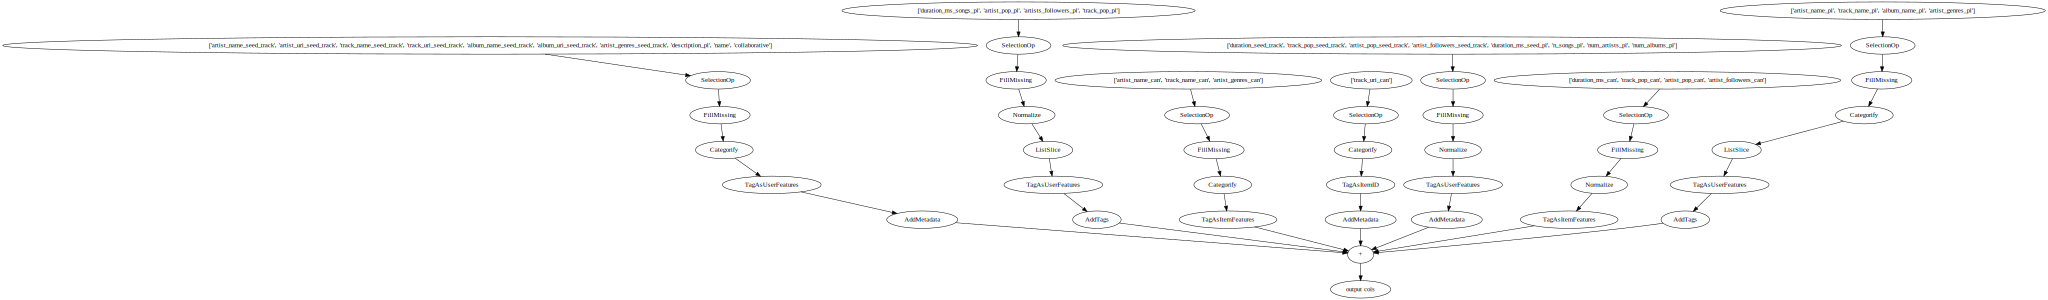

In [6]:
output.graph

In [7]:
import pandas as pd

# Don't truncate text fields in the display
pd.set_option("display.max_colwidth", None)

valid.to_ddf().head(1)

,name,collaborative,pid,modified_at,row_number,pid_pos_id,pos_can,artist_name_can,track_uri_can,album_uri_can,...,pos_pl,artist_name_pl,track_uri_pl,track_name_pl,duration_ms_songs_pl,album_name_pl,artist_pop_pl,artists_followers_pl,track_pop_pl,artist_genres_pl
0,Bachatas,false,110570,1402531200,1,110570-19,19,Antony Santos,spotify:track:1QY9XJBQOcn3IK5pRLcBOO,spotify:album:0MH8l6reBKR0XiruVFbfqF,...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]","[Anthony Santos, Aventura, Anthony Santos, Anthony Santos, Anthony Santos, Antony Santos, Antony Santos, El Varon de la bachata, Anthony Santos, Antony Santos, Antony Santos, Antony Santos, Antony Santos, Antony Santos, Antony Santos, Antony Santos, Antony Santos, Antony Santos, Antony Santos]","[spotify:track:53orRX6MudB9jhW0sKZWhW, spotify:track:1IdSPagRNE4i6cr6I8QBYD, spotify:track:6euDBuLIZBxCkVtp4nDaH2, spotify:track:2VJbILxAug6exqbL3PIcwl, spotify:track:59ATfWn17IAgrOAdY4NYbi, spotify:track:6WQx5OQx4hiF1CfAmcW0pI, spotify:track:2cKGzCcBEnN9BmhR1FOvRM, spotify:track:4b1ULLyRgU6FZhb9yQ7E1D, spotify:track:1uDBAmQziJZi8U5KTW31RW, spotify:track:1sg7s8xWr14UJ1vqIilqot, spotify:track:3mAsGaP2iww8IrFOeYcQxw, spotify:track:55VkPG0F93r4gYkYXBetfE, spotify:track:1soZPkNYncKsVnSk18OGTP, spotify:track:1ARBfSAwF3zDJMsBRSKik3, spotify:track:6WQx5OQx4hiF1CfAmcW0pI, spotify:track:6xRna2ZXwaiUN39EyDHFu2, spotify:track:7AO5llDSXH7lzr3T1K02E4, spotify:track:0PWL8Nxk9tekRswIeTNMJX, spotify:track:0OrRg7Aa1aJvysYPVOJRHJ]","[Creiste, Ciego De Amor - Featuring Anthony Santos, Me Enamoro, Golpes en el corazon, Me quiere la otra, Lloro, Matame, No Es Brujeria, Vete Y Aléjate De Mí, Por Mi Timedez, Sone Con Ella, Pegame Tu Vicio, Yo Me Muero Por Ti, Ay Amor, Lloro, Ay! Ven - Bachata, Mi Primera Vez, Consejo De Padre, Ay, Ay, Ay]","[257463.0, 307933.0, 258064.0, 295600.0, 277253.0, 339480.0, 208586.0, 248600.0, 274645.0, 282626.0, 277253.0, 372733.0, 392695.0, 317813.0, 339480.0, 279360.0, 269280.0, 358666.0, 334533.0]","[Creiste, God's Project, Me Enamoro, Vuelve, Vuelve, Lloro, Lloro, Alma Perdida, 25 Grandes Exitos, Aqui Esta La Bachata Vol. 2, Como Te Voy A Dejar, Enamorado, La Batalla, El Mayimbe Vuelve En Vivo, Lloro, Ay! Ven, Lloro, Sabor Latino, El Mayimbe Vuelve En Vivo]","[65.0, 82.0, 65.0, 65.0, 65.0, 65.0, 65.0, 46.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0]","[660113.0, 5632583.0, 660113.0, 660113.0, 660113.0, 0.0, 0.0, 81821.0, 660113.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[54.0, 64.0, 33.0, 0.0, 0.0, 40.0, 48.0, 55.0, 0.0, 41.0, 49.0, 56.0, 51.0, 35.0, 40.0, 38.0, 39.0, 26.0, 33.0]","['bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'latin', 'latin hip hop', 'latin pop', 'trap latino', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'latin', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical']"


Now set the output buckets for the validation and training

In [8]:
output_path = os.path.join(BUCKET, "merlin-processed")
output_train_dir = os.path.join(output_path, 'train/')
output_valid_dir = os.path.join(output_path, 'valid/')
output_workflow_dir = os.path.join(output_path, 'workflow/')


print(f"Train data dir: {output_train_dir}\nValid data dir: {output_valid_dir}")

Train data dir: gs://spotify-builtin-2t/merlin-processed/train/
Valid data dir: gs://spotify-builtin-2t/merlin-processed/valid/


## Load and preprocess training data back to Parquet GCS
helpful resources https://cloud.google.com/compute/docs/gpus/monitor-gpus

Number of files in input bucket
```
jwortz-macbookpro:merlin-workflow-download jwortz$ gsutil ls -lR gs://spotify-builtin-2t/train_data_parquet | tail -n 1
TOTAL: 5000 objects, 326467491281 bytes (304.05 GiB)

jwortz-macbookpro:merlin-workflow-download jwortz$ gsutil ls -lR gs://spotify-builtin-2t/validation_data_parquet | tail -n 1
TOTAL: 152 objects, 16521928490 bytes (15.39 GiB)
```


In [12]:
%%time

time_preproc = 0
time_preproc_start = time()

workflow.fit_transform(train).to_parquet(output_path=output_train_dir, 
                                         shuffle=nvt.io.Shuffle.PER_PARTITION,
                                         cats=CAT,
                                         conts=CONT, 
                                         output_files = 50
                                         ) #preserve_files=True keeps the original file sharding


time_preproc += time()-time_preproc_start

/usr/local/lib/python3.8/dist-packages/cudf/core/dataframe.py:1292: UserWarning: The deep parameter is ignored and is only included for pandas compatibility.
  warnings.warn(


CPU times: user 4min 39s, sys: 2min 59s, total: 7min 38s
Wall time: 12min 41s


In [13]:
#save the workflow to disk after it has been fit
workflow.save(os.path.join(output_workflow_dir,'2t-spotify-workflow'))

#locally for demo too
workflow.save('2t-spotify-workflow')

In [14]:
schema = workflow.output_schema

schema

[{'name': 'track_uri_can', 'tags': {<Tags.CATEGORICAL: 'categorical'>, <Tags.ITEM: 'item'>, <Tags.ITEM_ID: 'item_id'>, 'user_item'}, 'properties': {'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.track_uri_can.parquet', 'domain': {'min': 0, 'max': 258189}, 'embedding_sizes': {'cardinality': 258189, 'dimension': 512}}, 'dtype': dtype('int32'), 'is_list': False, 'is_ragged': False}, {'name': 'artist_name_can', 'tags': {<Tags.ITEM: 'item'>, <Tags.CATEGORICAL: 'categorical'>}, 'properties': {'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.artist_name_can.parquet', 'domain': {'min': 0, 'max': 57696}, 'embedding_sizes': {'cardinality': 57696, 'dimension': 512}}, 'dtype': dtype('int32'), 'is_list': False, 'is_ragged': False}, {'name': 'track_name_can', 'tags': {<Tags.ITEM: 'item'>, <Tags.CATEGORICAL: 'categorical'>}, 'properties': {'num_buckets': None, 'freq_threshold': 0,

## Load and preprocess validation

In [15]:
%%time

time_preproc_start = time()
wf_valid_op = workflow.transform(valid).to_parquet(output_path=output_valid_dir, 
                                         shuffle=nvt.io.Shuffle.PER_PARTITION,
                                         cats=CAT,
                                         conts=CONT,
                                         output_files=10
                                         )


time_preproc += time()-time_preproc_start

CPU times: user 8.91 s, sys: 6.78 s, total: 15.7 s
Wall time: 30.5 s


In [16]:
nvtdata = pd.read_parquet(output_train_dir+'part_0.parquet')
nvtdata['track_name_pl'].head(3) #should see padded lists

0    [519369, 435095, 552107, 380139, 515425, 519187, 520736, 502396, 520597, 356044, 187751, 515500, 221380, 513521, 513242, 329449, 556845, 358712, 513098, 162580, 423377, 298108, 433868, 434626, 451135, 417353, 555421, 451008, 385881, 513984, 263439, 556763, 319748, 402128, 209333, 498544, 499979, 518871, 183096, 207244, 264460, 388347, 498147, 229977, 499655, 505262, 213609, 308356, 267254, 311583, 223790, 210165, 97298, 482812, 496730, 353447, 302499, 505110, 330681, 361927, 450239, 461519, 292661, 93773, 325201, 325389, 480819, 351273, 497714, 362308, 513143, 288327, 480578, 498296, 534501, 513989, 551859, 482013, 298108, 360450, 324925, 368609, 267251, 397799, 260572, 562030, 475918, 400553, 667732, 348198, 607836, 649987, 352932, 232338, 371418, 475844, 439572, 316961, 298718, 587239, ...]
1                                                                                                                                                                                              

In [17]:
nvtdata = pd.read_parquet(output_train_dir+'part_0.parquet')
nvtdata['artist_name_seed_track'].head(10)

0     7144
1       22
2      211
3      777
4    11571
5     2406
6      249
7      114
8     4500
9      266
Name: artist_name_seed_track, dtype: int32

In [18]:
len(nvtdata)

24566

In [ ]:
embeddings = ops.get_embedding_sizes(workflow)
embeddings

({'track_uri_can': (258189, 512),
  'artist_name_can': (57696, 512),
  'track_name_can': (196107, 512),
  'artist_genres_can': (20511, 416),
  'artist_name_seed_track': (57557, 512),
  'artist_uri_seed_track': (58165, 512),
  'track_name_seed_track': (195896, 512),
  'track_uri_seed_track': (257894, 512),
  'album_name_seed_track': (112919, 512),
  'album_uri_seed_track': (134740, 512),
  'artist_genres_seed_track': (20431, 415),
  'description_pl': (11574, 302),
  'name': (72117, 512),
  'collaborative': (3, 16)},
 {'artist_name_pl': (211490, 512),
  'track_name_pl': (1086902, 512),
  'album_name_pl': (426100, 512),
  'artist_genres_pl': (34844, 512)})

In [ ]:
print([embeddings[0][x] for x in item_feature_cat_node.output_columns.names])

[(57696, 512), (196107, 512), (20511, 416)]


In [ ]:
playlist_feature_cont_node.output_columns.names

['duration_seed_track',
 'track_pop_seed_track',
 'artist_pop_seed_track',
 'artist_followers_seed_track',
 'duration_ms_seed_pl',
 'n_songs_pl',
 'num_artists_pl',
 'num_albums_pl']

# Load the processed data into a Merlin Dataset and inspect the transforms

Now that ETL is over, the workflow is saved and data is processed to the `output_path`

In [ ]:
# !gcloud set project-id hybrid-vertex

In [ ]:
!gsutil cp -r {output_workflow_dir} .

In [9]:
# load back the workflow and schema

workflow = nvt.Workflow.load("gs://spotify-builtin-2t/merlin-processed/workflow/2t-spotify-workflow")
schema = workflow.output_schema
embeddings = ops.get_embedding_sizes(workflow)
embeddings

{'track_uri_can': (258189, 512),
 'artist_name_can': (57696, 512),
 'track_name_can': (196107, 512),
 'artist_genres_can': (20511, 416),
 'artist_name_seed_track': (57557, 512),
 'artist_uri_seed_track': (58165, 512),
 'track_name_seed_track': (195896, 512),
 'track_uri_seed_track': (257894, 512),
 'album_name_seed_track': (112919, 512),
 'album_uri_seed_track': (134740, 512),
 'artist_genres_seed_track': (20431, 415),
 'description_pl': (11574, 302),
 'name': (72117, 512),
 'collaborative': (3, 16),
 'artist_name_pl': (211490, 512),
 'track_name_pl': (1086902, 512),
 'album_name_pl': (426100, 512),
 'artist_genres_pl': (34844, 512)}

In [10]:
from merlin.models.utils.example_utils import workflow_fit_transform

from merlin.schema.tags import Tags

import merlin.models.tf as mm
from merlin.io.dataset import Dataset as MerlinDataset

train = MerlinDataset(output_train_dir + "/*.parquet", schema=schema, part_size="500MB")
valid = MerlinDataset(output_valid_dir + "/*.parquet", schema=schema, part_size="500MB")

#look at output
schema = train.schema

/usr/local/lib/python3.8/dist-packages/cudf/core/dataframe.py:1292: UserWarning: The deep parameter is ignored and is only included for pandas compatibility.
  warnings.warn(


In [11]:
import pandas as pd
pd.DataFrame(schema)

,name,tags,properties,dtype,is_list,is_ragged
0,track_uri_can,"(Tags.ITEM, Tags.CATEGORICAL, user_item, Tags.ITEM_ID)","{'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.track_uri_can.parquet', 'domain': {'min': 0, 'max': 258189}, 'embedding_sizes': {'cardinality': 258189, 'dimension': 512}}",int32,False,False
1,artist_name_can,"(Tags.ITEM, Tags.CATEGORICAL)","{'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.artist_name_can.parquet', 'domain': {'min': 0, 'max': 57696}, 'embedding_sizes': {'cardinality': 57696, 'dimension': 512}}",int32,False,False
2,track_name_can,"(Tags.ITEM, Tags.CATEGORICAL)","{'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.track_name_can.parquet', 'domain': {'min': 0, 'max': 196107}, 'embedding_sizes': {'cardinality': 196107, 'dimension': 512}}",int32,False,False
3,artist_genres_can,"(Tags.ITEM, Tags.CATEGORICAL)","{'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.artist_genres_can.parquet', 'domain': {'min': 0, 'max': 20511}, 'embedding_sizes': {'cardinality': 20511, 'dimension': 416}}",int32,False,False
4,duration_ms_can,"(Tags.ITEM, Tags.CONTINUOUS)",{},float64,False,False
5,track_pop_can,"(Tags.ITEM, Tags.CONTINUOUS)",{},float64,False,False
6,artist_pop_can,"(Tags.ITEM, Tags.CONTINUOUS)",{},float64,False,False
7,artist_followers_can,"(Tags.ITEM, Tags.CONTINUOUS)",{},float64,False,False
8,artist_name_seed_track,"(Tags.CATEGORICAL, Tags.CONTEXT, Tags.USER)","{'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.artist_name_seed_track.parquet', 'domain': {'min': 0, 'max': 57557}, 'embedding_sizes': {'cardinality': 57557, 'dimension': 512}}",int32,False,False
9,artist_uri_seed_track,"(Tags.CATEGORICAL, Tags.CONTEXT, Tags.USER)","{'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.artist_uri_seed_track.parquet', 'domain': {'min': 0, 'max': 58165}, 'embedding_sizes': {'cardinality': 58165, 'dimension': 512}}",int32,False,False


Direct quote from [here](https://github.com/NVIDIA-Merlin/models/blob/main/examples/05-Retrieval-Model.ipynb)

### Negative sampling
Many datasets for recommender systems contain implicit feedback with logs of user interactions like clicks, add-to-cart, purchases, music listening events, rather than explicit ratings that reflects user preferences over items. To be able to learn from implicit feedback, we use the general (and naive) assumption that the interacted items are more relevant for the user than the non-interacted ones. In Merlin Models we provide some scalable negative sampling algorithms for the Item Retrieval Task. In particular, we use in this example the in-batch sampling algorithm which uses the items interacted by other users as negatives within the same mini-batch.

### Building the Model
Now, let's build our Two-Tower model. In a nutshell, we aggregate all user features to feed in user tower and feed the item features to the item tower. Then we compute the positive score by multiplying the user embedding with the item embedding and sample negative items (read more about negative sampling here and here), whose item embeddings are also multiplied by the user embedding. Then we apply the loss function on top of the positive and negative scores.

#### Get a batch to QA and build the model

In [3]:
batch = mm.sample_batch(valid, batch_size=5, shuffle=False, include_targets=False)

NameError: name 'valid' is not defined

In [20]:
output = user_base_layers(batch)
for k, v in output.items():
    print(k, v.shape)

NameError: name 'user_base_layers' is not defined

In [14]:
for k, v in batch.items():
    print(k, v[0].shape)

artist_name_pl (287, 1)
track_name_pl (287, 1)
album_name_pl (287, 1)
artist_genres_pl (287, 1)
track_uri_can (1,)
artist_name_can (1,)
track_name_can (1,)
artist_genres_can (1,)
artist_name_seed_track (1,)
artist_uri_seed_track (1,)
track_name_seed_track (1,)
track_uri_seed_track (1,)
album_name_seed_track (1,)
album_uri_seed_track (1,)
artist_genres_seed_track (1,)
description_pl (1,)
name (1,)
collaborative (1,)
pid_pos_id (1,)
duration_ms_songs_pl (287, 1)
artist_pop_pl (287, 1)
artists_followers_pl (287, 1)
track_pop_pl (287, 1)
duration_ms_can (1,)
track_pop_can (1,)
artist_pop_can (1,)
artist_followers_can (1,)
duration_seed_track (1,)
track_pop_seed_track (1,)
artist_pop_seed_track (1,)
artist_followers_seed_track (1,)
duration_ms_seed_pl (1,)
n_songs_pl (1,)
num_artists_pl (1,)
num_albums_pl (1,)


##### Try to reshape the input so ragged is embedded, averaged and has the right shape of (BATCH_SIZE, None)

In [31]:
pd.DataFrame(schema.select_by_tag(Tags.ITEM))

,name,tags,properties,dtype,is_list,is_ragged
0,track_uri_can,"(Tags.CATEGORICAL, Tags.ITEM_ID, Tags.ITEM, us...","{'num_buckets': None, 'freq_threshold': 0, 'ma...",int32,False,False
1,artist_name_can,"(Tags.CATEGORICAL, Tags.ITEM)","{'num_buckets': None, 'freq_threshold': 0, 'ma...",int32,False,False
2,track_name_can,"(Tags.CATEGORICAL, Tags.ITEM)","{'num_buckets': None, 'freq_threshold': 0, 'ma...",int32,False,False
3,artist_genres_can,"(Tags.CATEGORICAL, Tags.ITEM)","{'num_buckets': None, 'freq_threshold': 0, 'ma...",int32,False,False
4,duration_ms_can,"(Tags.CONTINUOUS, Tags.ITEM)",{},float64,False,False
5,track_pop_can,"(Tags.CONTINUOUS, Tags.ITEM)",{},float64,False,False
6,artist_pop_can,"(Tags.CONTINUOUS, Tags.ITEM)",{},float64,False,False
7,artist_followers_can,"(Tags.CONTINUOUS, Tags.ITEM)",{},float64,False,False


In [32]:
embedding_block = mm.EmbeddingFeatures.from_schema(schema.select_by_tag(Tags.ITEM), tags=Tags.ITEM)
embedding_block

EmbeddingFeatures(
  (feature_config): Dict(
    (track_uri_can): TableConfig(vocabulary_size=258190, dim=64, initializer=None, optimizer=None, combiner='mean', name='track_uri_can')
    (artist_name_can): TableConfig(vocabulary_size=57697, dim=64, initializer=None, optimizer=None, combiner='mean', name='artist_name_can')
    (track_name_can): TableConfig(vocabulary_size=196108, dim=64, initializer=None, optimizer=None, combiner='mean', name='track_name_can')
    (artist_genres_can): TableConfig(vocabulary_size=20512, dim=64, initializer=None, optimizer=None, combiner='mean', name='artist_genres_can')
  )
  (_pre): SequentialBlock(
    (layers): List(
      (0): Filter(
        (feature_names): List(
          (0): 'track_uri_can'
          (1): 'artist_name_can'
          (2): 'track_name_can'
          (3): 'artist_genres_can'
        )
      )
      (1): AsSparseFeatures()
    )
  )
)

In [22]:
out = user_base_layers(batch)
print("PLAYLIST BASE LAYERS \n")
for k, v in out.items():
    print(k, v.shape)
print("\n")
out = item_base_layers(batch)
print("ITEM BASE LAYERS \n")
for k, v in out.items():
    print(k, v.shape)

PLAYLIST BASE LAYERS 

artist_name_pl (5, 64)
track_name_pl (5, 64)
album_name_pl (5, 64)
artist_genres_pl (5, 64)
artist_name_seed_track (5, 64)
artist_uri_seed_track (5, 64)
track_name_seed_track (5, 64)
track_uri_seed_track (5, 64)
album_name_seed_track (5, 64)
album_uri_seed_track (5, 64)
artist_genres_seed_track (5, 64)
description_pl (5, 64)
name (5, 64)
collaborative (5, 64)
duration_seed_track (5, 1)
track_pop_seed_track (5, 1)
artist_pop_seed_track (5, 1)
artist_followers_seed_track (5, 1)
duration_ms_seed_pl (5, 1)
n_songs_pl (5, 1)
num_artists_pl (5, 1)
num_albums_pl (5, 1)


ITEM BASE LAYERS 

track_uri_can (5, 64)
artist_name_can (5, 64)
track_name_can (5, 64)
artist_genres_can (5, 64)
duration_ms_can (5, 1)
track_pop_can (5, 1)
artist_pop_can (5, 1)
artist_followers_can (5, 1)


In [21]:
from merlin.schema import Tags


def create_base_layers(tower_tag, cont_features):
    embedding_block = mm.EmbeddingFeatures.from_schema(schema.select_by_tag(tower_tag), tags=tower_tag)
    continuous_block = mm.ContinuousFeatures.from_features(cont_features)
    dlrm_input_block = mm.ParallelBlock(
        {"embeddings": embedding_block, "continuous": continuous_block} # we will use the deep continuous for interaction terms
    )
    return(dlrm_input_block)

user_base_layers = create_base_layers([Tags.USER], playlist_features_cont)
item_base_layers = create_base_layers([Tags.ITEM], item_features_cont)

user_tower = user_base_layers.connect(
    mm.MLPBlock([512, 256])
)
    
item_tower = item_base_layers.connect(
    mm.MLPBlock([512, 256])
)

two_tower = mm.ParallelBlock({"user": user_tower, "item": item_tower})

model = mm.Model(two_tower, mm.ItemRetrievalTask(schema,
                                                samplers=[mm.InBatchSampler()]
                                                ))

type(model)

merlin.models.tf.models.base.Model

In [23]:
model.compile(optimizer="adam", run_eagerly=False, metrics=[mm.RecallAt(1), mm.RecallAt(10), mm.NDCGAt(10)])
model.fit(train, validation_data=valid, batch_size=16, epochs=10)

2022-07-29 20:38:08.033427: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


KeyError: 'Exception encountered when calling layer "model" (type Model).\n\nquery\n\nCall arguments received:\n  • inputs={\'artist_name_pl\': (\'tf.Tensor(shape=(6000, 1), dtype=int32)\', \'tf.Tensor(shape=(16, 1), dtype=int32)\'), \'track_name_pl\': (\'tf.Tensor(shape=(6000, 1), dtype=int32)\', \'tf.Tensor(shape=(16, 1), dtype=int32)\'), \'album_name_pl\': (\'tf.Tensor(shape=(6000, 1), dtype=int32)\', \'tf.Tensor(shape=(16, 1), dtype=int32)\'), \'artist_genres_pl\': (\'tf.Tensor(shape=(6000, 1), dtype=int32)\', \'tf.Tensor(shape=(16, 1), dtype=int32)\'), \'track_uri_can\': \'tf.Tensor(shape=(16, 1), dtype=int32)\', \'artist_name_can\': \'tf.Tensor(shape=(16, 1), dtype=int32)\', \'track_name_can\': \'tf.Tensor(shape=(16, 1), dtype=int32)\', \'artist_genres_can\': \'tf.Tensor(shape=(16, 1), dtype=int32)\', \'artist_name_seed_track\': \'tf.Tensor(shape=(16, 1), dtype=int32)\', \'artist_uri_seed_track\': \'tf.Tensor(shape=(16, 1), dtype=int32)\', \'track_name_seed_track\': \'tf.Tensor(shape=(16, 1), dtype=int32)\', \'track_uri_seed_track\': \'tf.Tensor(shape=(16, 1), dtype=int32)\', \'album_name_seed_track\': \'tf.Tensor(shape=(16, 1), dtype=int32)\', \'album_uri_seed_track\': \'tf.Tensor(shape=(16, 1), dtype=int32)\', \'artist_genres_seed_track\': \'tf.Tensor(shape=(16, 1), dtype=int32)\', \'description_pl\': \'tf.Tensor(shape=(16, 1), dtype=int32)\', \'name\': \'tf.Tensor(shape=(16, 1), dtype=int32)\', \'collaborative\': \'tf.Tensor(shape=(16, 1), dtype=int32)\', \'duration_ms_songs_pl\': (\'tf.Tensor(shape=(6000, 1), dtype=float32)\', \'tf.Tensor(shape=(16, 1), dtype=int32)\'), \'artist_pop_pl\': (\'tf.Tensor(shape=(6000, 1), dtype=float32)\', \'tf.Tensor(shape=(16, 1), dtype=int32)\'), \'artists_followers_pl\': (\'tf.Tensor(shape=(6000, 1), dtype=float32)\', \'tf.Tensor(shape=(16, 1), dtype=int32)\'), \'track_pop_pl\': (\'tf.Tensor(shape=(6000, 1), dtype=float32)\', \'tf.Tensor(shape=(16, 1), dtype=int32)\'), \'duration_ms_can\': \'tf.Tensor(shape=(16, 1), dtype=float32)\', \'track_pop_can\': \'tf.Tensor(shape=(16, 1), dtype=float32)\', \'artist_pop_can\': \'tf.Tensor(shape=(16, 1), dtype=float32)\', \'artist_followers_can\': \'tf.Tensor(shape=(16, 1), dtype=float32)\', \'duration_seed_track\': \'tf.Tensor(shape=(16, 1), dtype=float32)\', \'track_pop_seed_track\': \'tf.Tensor(shape=(16, 1), dtype=float32)\', \'artist_pop_seed_track\': \'tf.Tensor(shape=(16, 1), dtype=float32)\', \'artist_followers_seed_track\': \'tf.Tensor(shape=(16, 1), dtype=float32)\', \'duration_ms_seed_pl\': \'tf.Tensor(shape=(16, 1), dtype=float32)\', \'n_songs_pl\': \'tf.Tensor(shape=(16, 1), dtype=float32)\', \'num_artists_pl\': \'tf.Tensor(shape=(16, 1), dtype=float32)\', \'num_albums_pl\': \'tf.Tensor(shape=(16, 1), dtype=float32)\'}\n  • kwargs={\'training\': \'False\'}'

### Shapes look good now need to connect this to the two tower model
Use lower-level API

In [85]:
two_tower = mm.TwoTowerModel(
    schema,
    query_tower=mm.MLPBlock([128, 64], no_activation_last_layer=True),
    item_tower=mm.MLPBlock([128, 64], no_activation_last_layer=True),
    samplers=[mm.InBatchSampler()],
    embedding_options=mm.EmbeddingOptions(infer_embedding_sizes=True),
)

## Cant get this to work

In [78]:
%%time

two_tower.compile(optimizer="adam", run_eagerly=False, metrics=[mm.RecallAt(1), mm.RecallAt(10), mm.NDCGAt(10)])

model_w_input = dlrm_input_block.connect(two_tower)

model_w_input(batch)

# model_w_input.compile(optimizer="adam", run_eagerly=False, metrics=[mm.RecallAt(1), mm.RecallAt(10), mm.NDCGAt(10)])


# pre_calc_data = pre_calc.as_tabular(train)
# model_w_input.fit(train, validation_data=valid, batch_size=2048, epochs=3)

CPU times: user 1.09 s, sys: 51.1 ms, total: 1.14 s
Wall time: 1.02 s


<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.3490993 ],
       [0.33997512],
       [0.27892786],
       [0.27734518],
       [0.33156052]], dtype=float32)>

## Appendix

In [29]:
two_t_schema_seq.column_names

['duration_ms_songs_pl',
 'artist_pop_pl',
 'artists_followers_pl',
 'track_pop_pl',
 'artist_name_pl',
 'track_name_pl',
 'album_name_pl',
 'artist_genres_pl']

In [36]:
embeddings['track_uri_can']

(258189, 512)

In [17]:
two_t_schema = schema.select_by_tag([Tags.ITEM_ID, Tags.ITEM, Tags.USER, Tags.USER_ID])

In [23]:
?mm.EmbeddingFeatures

Init signature: mm.EmbeddingFeatures(*args, **kwargs)
Docstring:     
Input block for embedding-lookups for categorical features.

For multi-hot features, the embeddings will be aggregated into a single tensor using the mean.

Parameters
----------

feature_config: Dict[str, FeatureConfig]
    This specifies what TableConfig to use for each feature. For shared embeddings, the same
    TableConfig can be used for multiple features.
item_id: str, optional
    The name of the feature that's used for the item_id.


pre: Union[str, TabularTransformation, List[str], List[TabularTransformation]], optional
    Transformations to apply on the inputs when the module is called (so **before** `call`).
post: Union[str, TabularTransformation, List[str], List[TabularTransformation]], optional
    Transformations to apply on the inputs after the module is called (so **after** `call`).
aggregation: Union[str, TabularAggregation], optional
    Aggregation to apply after processing the `call`-method to o

In [44]:
import pandas as pd
pd.DataFrame(schema)

,name,tags,properties,dtype,is_list,is_ragged
0,track_uri_can,"(Tags.ITEM_ID, Tags.CATEGORICAL, Tags.ITEM, user_item)","{'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.track_uri_can.parquet', 'domain': {'min': 0, 'max': 258189}, 'embedding_sizes': {'cardinality': 258189, 'dimension': 512}}",int32,False,False
1,artist_name_can,"(Tags.CATEGORICAL, Tags.ITEM)","{'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.artist_name_can.parquet', 'domain': {'min': 0, 'max': 57696}, 'embedding_sizes': {'cardinality': 57696, 'dimension': 512}}",int32,False,False
2,track_name_can,"(Tags.CATEGORICAL, Tags.ITEM)","{'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.track_name_can.parquet', 'domain': {'min': 0, 'max': 196107}, 'embedding_sizes': {'cardinality': 196107, 'dimension': 512}}",int32,False,False
3,artist_genres_can,"(Tags.CATEGORICAL, Tags.ITEM)","{'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.artist_genres_can.parquet', 'domain': {'min': 0, 'max': 20511}, 'embedding_sizes': {'cardinality': 20511, 'dimension': 416}}",int32,False,False
4,duration_ms_can,"(Tags.CONTINUOUS, Tags.ITEM)",{},float64,False,False
5,track_pop_can,"(Tags.CONTINUOUS, Tags.ITEM)",{},float64,False,False
6,artist_pop_can,"(Tags.CONTINUOUS, Tags.ITEM)",{},float64,False,False
7,artist_followers_can,"(Tags.CONTINUOUS, Tags.ITEM)",{},float64,False,False
8,artist_name_seed_track,"(Tags.CONTEXT, Tags.CATEGORICAL, Tags.USER)","{'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.artist_name_seed_track.parquet', 'domain': {'min': 0, 'max': 57557}, 'embedding_sizes': {'cardinality': 57557, 'dimension': 512}}",int32,False,False
9,artist_uri_seed_track,"(Tags.CONTEXT, Tags.CATEGORICAL, Tags.USER)","{'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.artist_uri_seed_track.parquet', 'domain': {'min': 0, 'max': 58165}, 'embedding_sizes': {'cardinality': 58165, 'dimension': 512}}",int32,False,False


In [26]:
?mm.EmbeddingFeatures

Init signature: mm.EmbeddingFeatures(*args, **kwargs)
Docstring:     
Input block for embedding-lookups for categorical features.

For multi-hot features, the embeddings will be aggregated into a single tensor using the mean.

Parameters
----------

feature_config: Dict[str, FeatureConfig]
    This specifies what TableConfig to use for each feature. For shared embeddings, the same
    TableConfig can be used for multiple features.
item_id: str, optional
    The name of the feature that's used for the item_id.


pre: Union[str, TabularTransformation, List[str], List[TabularTransformation]], optional
    Transformations to apply on the inputs when the module is called (so **before** `call`).
post: Union[str, TabularTransformation, List[str], List[TabularTransformation]], optional
    Transformations to apply on the inputs after the module is called (so **after** `call`).
aggregation: Union[str, TabularAggregation], optional
    Aggregation to apply after processing the `call`-method to o

In [36]:
schema.select_by_tag([Tags.ITEM_ID])

[{'name': 'track_uri_can', 'tags': {<Tags.ITEM_ID: 'item_id'>, <Tags.CATEGORICAL: 'categorical'>, <Tags.ITEM: 'item'>, 'user_item'}, 'properties': {'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.track_uri_can.parquet', 'domain': {'min': 0, 'max': 258189}, 'embedding_sizes': {'cardinality': 258189, 'dimension': 512}}, 'dtype': dtype('int32'), 'is_list': False, 'is_ragged': False}]

In [38]:
batch = mm.sample_batch(valid, batch_size=5, shuffle=False, include_targets=False)
batch

{'artist_name_pl': (<tf.Tensor: shape=(238, 1), dtype=int32, numpy=
  array([[  2376],
         [  2376],
         [   239],
         [   239],
         [   239],
         [   270],
         [  2112],
         [  1784],
         [  1784],
         [   427],
         [   239],
         [   239],
         [  1280],
         [  2219],
         [  1248],
         [   163],
         [   163],
         [   239],
         [   408],
         [  1477],
         [  2992],
         [  2992],
         [  2101],
         [  2219],
         [  1844],
         [  1582],
         [   427],
         [  2037],
         [  2104],
         [  1763],
         [  1942],
         [  1763],
         [  1190],
         [  2035],
         [  4351],
         [   499],
         [ 16282],
         [ 12666],
         [ 16282],
         [ 16282],
         [ 12371],
         [ 12371],
         [ 12371],
         [ 12371],
         [ 23646],
         [ 23646],
         [  1591],
         [   439],
         [   176],
 

In [45]:
sub_schema = train.schema.select_by_name(
    [
        "track_uri_can",
        "track_name_pl",
        "artist_pop_seed_track",
        "num_artists_pl",
        "num_songs_pl",
    ]
)

In [13]:

workflow = nvt.Workflow.load("gs://spotify-builtin-2t/merlin-processed/workflow/2t-spotify-workflow")
embeddings = ops.get_embedding_sizes(workflow)
embeddings




{'track_uri_can': (258189, 512),
 'artist_name_can': (57696, 512),
 'track_name_can': (196107, 512),
 'artist_genres_can': (20511, 416),
 'artist_name_seed_track': (57557, 512),
 'artist_uri_seed_track': (58165, 512),
 'track_name_seed_track': (195896, 512),
 'track_uri_seed_track': (257894, 512),
 'album_name_seed_track': (112919, 512),
 'album_uri_seed_track': (134740, 512),
 'artist_genres_seed_track': (20431, 415),
 'description_pl': (11574, 302),
 'name': (72117, 512),
 'collaborative': (3, 16),
 'artist_name_pl': (211490, 512),
 'track_name_pl': (1086902, 512),
 'album_name_pl': (426100, 512),
 'artist_genres_pl': (34844, 512)}

In [14]:
two_t_schema_seq = schema.select_by_tag([Tags.SEQUENCE])
two_t_schema_seq

# load back the workflow and schema

workflow = nvt.Workflow.load("gs://spotify-builtin-2t/merlin-processed/workflow/2t-spotify-workflow")
embeddings = ops.get_embedding_sizes(workflow)

In [20]:
# seq_embedding_dict = {}
# for seq_feat in two_t_schema_seq.column_names:
#     seq_embedding_dict.update({seq_feat: embeddings[str(seq_feat)]})


# embedding_layer(batch)
# for 
# embedding_layer_reg = mm.EmbeddingFeatures(embeddings_reg, schema
# #                                     )

# emb_table = mm.EmbeddingFeatures(embeddings, schema)
# .from_schema

##YT Example
emb_table = mm.EmbeddingFeatures.from_schema(schema)

ytmodel = mm.YoutubeDNNRetrievalModel(schema, 
                                      num_sampled=30, 
                                      max_seq_length=MAX_PADDING, 
                                      seq_aggregator=emb_table
                                     ) 

ytmodel.compile(optimizer="adam", run_eagerly=False, metrics=[mm.RecallAt(1), mm.RecallAt(10), mm.NDCGAt(10)])
ytmodel.fit(train, validation_data=valid, batch_size=128, epochs=10)

2022-07-29 21:14:31.950168: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


IndexError: Exception encountered when calling layer "model" (type Model).

list index out of range

Call arguments received:
  • inputs={'artist_name_pl': ('tf.Tensor(shape=(48000, 1), dtype=int32)', 'tf.Tensor(shape=(128, 1), dtype=int32)'), 'track_name_pl': ('tf.Tensor(shape=(48000, 1), dtype=int32)', 'tf.Tensor(shape=(128, 1), dtype=int32)'), 'album_name_pl': ('tf.Tensor(shape=(48000, 1), dtype=int32)', 'tf.Tensor(shape=(128, 1), dtype=int32)'), 'artist_genres_pl': ('tf.Tensor(shape=(48000, 1), dtype=int32)', 'tf.Tensor(shape=(128, 1), dtype=int32)'), 'track_uri_can': 'tf.Tensor(shape=(128, 1), dtype=int32)', 'artist_name_can': 'tf.Tensor(shape=(128, 1), dtype=int32)', 'track_name_can': 'tf.Tensor(shape=(128, 1), dtype=int32)', 'artist_genres_can': 'tf.Tensor(shape=(128, 1), dtype=int32)', 'artist_name_seed_track': 'tf.Tensor(shape=(128, 1), dtype=int32)', 'artist_uri_seed_track': 'tf.Tensor(shape=(128, 1), dtype=int32)', 'track_name_seed_track': 'tf.Tensor(shape=(128, 1), dtype=int32)', 'track_uri_seed_track': 'tf.Tensor(shape=(128, 1), dtype=int32)', 'album_name_seed_track': 'tf.Tensor(shape=(128, 1), dtype=int32)', 'album_uri_seed_track': 'tf.Tensor(shape=(128, 1), dtype=int32)', 'artist_genres_seed_track': 'tf.Tensor(shape=(128, 1), dtype=int32)', 'description_pl': 'tf.Tensor(shape=(128, 1), dtype=int32)', 'name': 'tf.Tensor(shape=(128, 1), dtype=int32)', 'collaborative': 'tf.Tensor(shape=(128, 1), dtype=int32)', 'duration_ms_songs_pl': ('tf.Tensor(shape=(48000, 1), dtype=float32)', 'tf.Tensor(shape=(128, 1), dtype=int32)'), 'artist_pop_pl': ('tf.Tensor(shape=(48000, 1), dtype=float32)', 'tf.Tensor(shape=(128, 1), dtype=int32)'), 'artists_followers_pl': ('tf.Tensor(shape=(48000, 1), dtype=float32)', 'tf.Tensor(shape=(128, 1), dtype=int32)'), 'track_pop_pl': ('tf.Tensor(shape=(48000, 1), dtype=float32)', 'tf.Tensor(shape=(128, 1), dtype=int32)'), 'duration_ms_can': 'tf.Tensor(shape=(128, 1), dtype=float32)', 'track_pop_can': 'tf.Tensor(shape=(128, 1), dtype=float32)', 'artist_pop_can': 'tf.Tensor(shape=(128, 1), dtype=float32)', 'artist_followers_can': 'tf.Tensor(shape=(128, 1), dtype=float32)', 'duration_seed_track': 'tf.Tensor(shape=(128, 1), dtype=float32)', 'track_pop_seed_track': 'tf.Tensor(shape=(128, 1), dtype=float32)', 'artist_pop_seed_track': 'tf.Tensor(shape=(128, 1), dtype=float32)', 'artist_followers_seed_track': 'tf.Tensor(shape=(128, 1), dtype=float32)', 'duration_ms_seed_pl': 'tf.Tensor(shape=(128, 1), dtype=float32)', 'n_songs_pl': 'tf.Tensor(shape=(128, 1), dtype=float32)', 'num_artists_pl': 'tf.Tensor(shape=(128, 1), dtype=float32)', 'num_albums_pl': 'tf.Tensor(shape=(128, 1), dtype=float32)'}
  • kwargs={'training': 'False'}

In [49]:
?mm.YoutubeDNNRetrievalModel

Docstring:
Build the Youtube-DNN retrieval model. More details of the model can be found in [1].

Example Usage::
    model = YoutubeDNNRetrievalModel(schema, num_sampled=100)
    model.compile(optimizer="adam")
    model.fit(train_data, epochs=10)

References
----------
[1] Covington, Paul, Jay Adams, and Emre Sargin.
    "Deep neural networks for youtube recommendations."
    Proceedings of the 10th ACM conference on recommender systems. 2016.


Parameters
----------
schema: Schema
    The `Schema` with the input features
aggregation: str
    The aggregation method to use for the sequence of features.
    Defaults to `concat`.
top_block: Block
    The `Block` that combines the top features
num_sampled: int
    The number of negative samples to use in the sampled-softmax.
    Defaults to 100.
loss: Optional[LossType]
    Loss function.
    Defaults to `categorical_crossentropy`.
metrics: List[Metric]
    List of metrics to use.
    Defaults to `ranking_metrics(top_ks=[10])`
normalize:

In [14]:
ytmodel.schema.select_by_tag(Tags.ITEM_ID)

[{'name': 'track_uri_can', 'tags': {<Tags.CATEGORICAL: 'categorical'>, <Tags.ITEM: 'item'>, <Tags.ITEM_ID: 'item_id'>, 'user_item'}, 'properties': {'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.track_uri_can.parquet', 'domain': {'min': 0, 'max': 258189}, 'embedding_sizes': {'cardinality': 258189, 'dimension': 512}}, 'dtype': dtype('int32'), 'is_list': False, 'is_ragged': False}]

In [69]:
train

In [68]:
?ytmodel.fit

Signature:
ytmodel.fit(
    x=None,
    y=None,
    batch_size=None,
    epochs=1,
    verbose='auto',
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    train_metrics_steps=1,
    **kwargs,
)
Docstring:
Trains the model for a fixed number of epochs (iterations on a dataset).

Args:
    x: Input data. It could be:
      - A Numpy array (or array-like), or a list of arrays
        (in case the model has multiple inputs).
      - A TensorFlow tensor, or a list of tensors
        (in case the model has multiple inputs).
      - A dict mapping input names to the corresponding array/tensors,
        if the model has named inputs.
      - A `tf.data` dataset. Should return a tuple
        of either `(inputs, 

In [57]:
ytmodel.

SyntaxError: invalid syntax (3186221044.py, line 1)

```
x never registered with registry tf.tabular_aggregations. Available:\n     add-left:\n      * add-left\n    concat:\n      * concat\n    cosine:\n      * cosine\n    cosine-similarity:\n      * cosine-similarity\n    element-wise-sum:\n      * element-wise-sum\n    element-wise-sum-item-multi:\n      * element-wise-sum-item-multi\n    elementwise-multiply:\n      * elementwise-multiply\n    stack:\n      * stack\n    sum:\n      * sum\n    sum-residual:\n      * sum-residual'
```

In [ ]:
?train.to_parquet

In [18]:
?ListSlice

Init signature: ListSlice(start, end=None, pad=False, pad_value=0.0)
Docstring:     
Slices a list column

This operator provides the ability to slice list column by row. For example, to truncate a
list column to only include the first 10 elements per row::

    truncated = column_names >> ops.ListSlice(10)

Take the first 10 items, ignoring the first element::

    truncated = column_names >> ops.ListSlice(1, 11)

Take the last 10 items from each row::

    truncated = column_names >> ops.ListSlice(-10)

Parameters
-----------
start: int
    The starting value to slice from if end isn't given, otherwise the end value to slice to
end: int, optional
    The end value to slice to
pad: bool, default False
    Whether to pad out rows to have the same number of elements. If not set rows may not all
    have the same number of entries.
pad_value: float
    When pad=True, this is the value used to pad missing entries
File:           /usr/local/lib/python3.8/dist-packages/nvtabular/ops/list_sl